# 1. Prepare Datasets

## 1.1 Import the S3 data into SageMaker

In [118]:
# Import packages
import boto3
import sagemaker
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [53]:
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


## 1.2 Store S3 locations

In [54]:
s3_public_path_kaggle = "s3://collegeaffordability317/Kaggle/"
s3_public_path_tuition = "s3://collegeaffordability317/TuitionTracker/"
s3_public_path_usda = "s3://collegeaffordability317/USDA/"

In [55]:
%store s3_public_path_kaggle
%store s3_public_path_tuition
%store s3_public_path_usda

Stored 's3_public_path_kaggle' (str)
Stored 's3_public_path_tuition' (str)
Stored 's3_public_path_usda' (str)


## 1.3 Show all the data files for the project

In [56]:
!aws s3 ls $s3_public_path_kaggle

2024-03-25 00:16:36   14081604 college_data.csv


In [57]:
!aws s3 ls $s3_public_path_tuition --recursive

2024-03-24 19:25:25          0 TuitionTracker/DataDictionary/
2024-03-24 19:25:37      21527 TuitionTracker/DataDictionary/DataDictionary.xlsx
2024-03-24 19:24:22          0 TuitionTracker/GradRates/
2024-03-24 19:24:45     838246 TuitionTracker/GradRates/GradRates.csv
2024-03-24 19:24:55          0 TuitionTracker/NetPrice/
2024-03-24 19:25:12    1319314 TuitionTracker/NetPrice/NetPrice.csv
2024-03-24 19:23:55          0 TuitionTracker/RetentionRates/
2024-03-24 19:24:08    1382164 TuitionTracker/RetentionRates/RetentionRates.csv
2024-03-24 19:20:50          0 TuitionTracker/StickerPrice/
2024-03-24 19:21:49     653000 TuitionTracker/StickerPrice/StickerPrice.csv


In [58]:
!aws s3 ls $s3_public_path_usda --recursive

2024-03-24 19:26:33          0 USDA/Education/
2024-03-24 19:26:58    1610608 USDA/Education/Education.xlsx
2024-03-24 19:28:03          0 USDA/PovertyEstimates/
2024-03-24 23:00:25     449799 USDA/PovertyEstimates/PovertyEstimates.csv
2024-03-25 22:15:58     187092 USDA/PovertyTableWithState/20240325_221556_00069_795ia_cfa99626-d392-4100-8b4f-0cfe8f1c1388.gz
2024-03-25 23:21:35     187092 USDA/PovertyTableWithState/20240325_232134_00063_r69ka_db087c21-7823-41ba-8bf6-04d122f8c50d.gz
2024-03-31 20:06:23     187092 USDA/PovertyTableWithState/20240331_200621_00076_h5iap_709e3c51-6e6e-4838-8662-f0807fbfbc84.gz
2024-03-24 19:28:24          0 USDA/Unemployment/
2024-03-24 22:59:49    1618804 USDA/Unemployment/Unemployment.csv


# 2. Athena DB

## 2.1 Data Wrangling

In [59]:
from pyathena import connect

# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [60]:
# Set Athena parameters
college_affordability_database = 'collegeaffordability317'
table_name = 'college_data'

In [61]:
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [62]:
statement = "CREATE DATABASE IF NOT EXISTS {}".format(college_affordability_database)
print(statement)
pd.read_sql(statement, conn)

CREATE DATABASE IF NOT EXISTS collegeaffordability317


""


In [63]:
statement = "SHOW DATABASES"

df_show = pd.read_sql(statement, conn)
df_show.head(10)

,database_name
0,collegeaffordability317
1,default
2,dsoaws


## 2.2 Populate Tables

In [64]:
tuition_tracker_dir = 's3://collegeaffordability317/TuitionTracker/'
usda_dir = 's3://collegeaffordability317/USDA/'
kaggle_dir = 's3://collegeaffordability317/Kaggle/'

In [65]:
# Drop the table if it already exists
university_table = 'University'
pd.read_sql(f'DROP TABLE IF EXISTS {college_affordability_database}.{university_table}', conn)

# Define the CREATE TABLE statement with data types in lowercase
create_university_table = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {college_affordability_database}.{university_table} (
    UNITID INT,
    INSTNM STRING,
    CITY STRING,
    STABBR STRING,
    ZIP STRING,
    REGION STRING,
    PREDDEG STRING,
    LOCALE INT,
    LATITUDE FLOAT,
    LONGITUDE FLOAT,
    CCBASIC STRING,
    CCUGPROF STRING,
    CCSIZSET STRING,
    ADM_RATE_ALL FLOAT,
    PPTUG_EF FLOAT,
    SAT_AVG_ALL INT,
    COSTT4_A INT,
    CONTROL STRING,
    TUITIONFEE_IN INT,
    TUITIONFEE_OUT INT,
    MEDIAN_HH_INC FLOAT,
    MN_EARN_WNE_INDEP0_P10 INT,
    MN_EARN_WNE_INDEP1_P10 INT,
    UGDS_WHITE FLOAT,
    UGDS_BLACK FLOAT,
    UGDS_HISP FLOAT,
    UGDS_ASIAN FLOAT,
    UGDS_AIAN FLOAT,
    UGDS_NHPI FLOAT,
    UGDS_2MOR FLOAT,
    UGDS_NRA FLOAT,
    UGDS_UNKN FLOAT,
    year INT
    )
    ROW FORMAT DELIMITED
    FIELDS TERMINATED BY ','
    LOCATION '{kaggle_dir}'
    TBLPROPERTIES ('skip.header.line.count'='1')
"""

# Execute create table statement
pd.read_sql(create_university_table, conn)

pd.read_sql(f'SELECT * FROM {college_affordability_database}.{university_table} LIMIT 5', conn)

,unitid,instnm,city,stabbr,zip,region,preddeg,locale,latitude,longitude,...,ugds_white,ugds_black,ugds_hisp,ugds_asian,ugds_aian,ugds_nhpi,ugds_2mor,ugds_nra,ugds_unkn,year
0,100654,Alabama A & M University,Normal,AL,35762,Southeast (AL AR FL GA KY LA MS NC SC TN VA WV),Predominantly bachelor's-degree granting,None,None,None,...,None,None,None,None,None,None,None,0.0402,0.0017,2001
1,100663,University of Alabama at Birmingham,Birmingham,AL,35294-0110,Southeast (AL AR FL GA KY LA MS NC SC TN VA WV),Predominantly bachelor's-degree granting,None,None,None,...,None,None,None,None,None,None,None,0.0330,0.0255,2001
2,100706,University of Alabama in Huntsville,Huntsville,AL,35899,Southeast (AL AR FL GA KY LA MS NC SC TN VA WV),Predominantly bachelor's-degree granting,None,None,None,...,None,None,None,None,None,None,None,0.0396,0.0000,2001
3,100751,The University of Alabama,Tuscaloosa,AL,35487-0100,Southeast (AL AR FL GA KY LA MS NC SC TN VA WV),Predominantly bachelor's-degree granting,None,None,None,...,None,None,None,None,None,None,None,0.0159,0.0000,2001
4,100858,Auburn University,Auburn,AL,36849,Southeast (AL AR FL GA KY LA MS NC SC TN VA WV),Predominantly bachelor's-degree granting,None,None,None,...,None,None,None,None,None,None,None,0.0084,0.0016,2001


In [66]:
# Drop the table if it already exists
sticker_price_table = 'StickerPrice'
pd.read_sql(f'DROP TABLE IF EXISTS {college_affordability_database}.{sticker_price_table}', conn)

# Define the CREATE TABLE statement with data types in lowercase
create_sticker_price_table = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {college_affordability_database}.{sticker_price_table} (
    unit_id INT,
    institution_name STRING,
    sector INT,
    total_price_in_state_on_campus_2021_2022 FLOAT,
    total_price_in_state_off_campus_wo_fam_2021_2022 FLOAT,
    total_price_in_state_off_campus_w_fam_2021_2022 FLOAT,
    total_price_in_state_on_campus_2020_2021 FLOAT,
    total_price_in_state_off_campus_wo_fam_2020_2021 FLOAT,
    total_price_in_state_off_campus_w_fam_2020_2021 FLOAT,
    total_price_in_state_on_campus_2019_2020 FLOAT,
    total_price_in_state_off_campus_wo_fam_2019_2020 FLOAT,
    total_price_in_state_off_campus_w_fam_2019_2020 FLOAT,
    total_price_in_state_on_campus_2018_2019 FLOAT,
    total_price_in_state_off_campus_wo_fam_2018_2019 FLOAT,
    total_price_in_state_off_campus_w_fam_2018_2019 FLOAT,
    total_price_in_state_on_campus_2017_2018 FLOAT,
    total_price_in_state_off_campus_wo_fam_2017_2018 FLOAT,
    total_price_in_state_off_campus_w_fam_2017_2018 FLOAT,
    total_price_in_state_on_campus_2016_2017 FLOAT,
    total_price_in_state_off_campus_wo_fam_2016_2017 FLOAT,
    total_price_in_state_off_campus_w_fam_2016_2017 FLOAT,
    total_price_in_state_on_campus_2015_2016 FLOAT,
    total_price_in_state_off_campus_wo_fam_2015_2016 FLOAT,
    total_price_in_state_off_campus_w_fam_2015_2016 FLOAT,
    total_price_in_state_on_campus_2014_2015 FLOAT,
    total_price_in_state_off_campus_wo_fam_2014_2015 FLOAT,
    total_price_in_state_off_campus_w_fam_2014_2015 FLOAT,
    total_price_in_state_on_campus_2013_2014 FLOAT,
    total_price_in_state_off_campus_wo_fam_2013_2014 FLOAT,
    total_price_in_state_off_campus_w_fam_2013_2014 FLOAT,
    total_price_in_state_on_campus_2012_2013 FLOAT,
    total_price_in_state_off_campus_wo_fam_2012_2013 FLOAT,
    total_price_in_state_off_campus_w_fam_2012_2013 FLOAT,
    total_price_in_state_on_campus_2011_2012 FLOAT,
    total_price_in_state_off_campus_wo_fam_2011_2012 FLOAT,
    total_price_in_state_off_campus_w_fam_2011_2012 FLOAT
    )
    ROW FORMAT DELIMITED
    FIELDS TERMINATED BY ','
    LOCATION '{tuition_tracker_dir}/{sticker_price_table}'
    TBLPROPERTIES ('skip.header.line.count'='1')
"""

# Execute create table statement
pd.read_sql(create_sticker_price_table, conn)

pd.read_sql(f'SELECT * FROM {college_affordability_database}.{sticker_price_table} LIMIT 5', conn)

,unit_id,institution_name,sector,total_price_in_state_on_campus_2021_2022,total_price_in_state_off_campus_wo_fam_2021_2022,total_price_in_state_off_campus_w_fam_2021_2022,total_price_in_state_on_campus_2020_2021,total_price_in_state_off_campus_wo_fam_2020_2021,total_price_in_state_off_campus_w_fam_2020_2021,total_price_in_state_on_campus_2019_2020,...,total_price_in_state_off_campus_w_fam_2014_2015,total_price_in_state_on_campus_2013_2014,total_price_in_state_off_campus_wo_fam_2013_2014,total_price_in_state_off_campus_w_fam_2013_2014,total_price_in_state_on_campus_2012_2013,total_price_in_state_off_campus_wo_fam_2012_2013,total_price_in_state_off_campus_w_fam_2012_2013,total_price_in_state_on_campus_2011_2012,total_price_in_state_off_campus_wo_fam_2011_2012,total_price_in_state_off_campus_w_fam_2011_2012
0,180203,Aaniiih Nakoda College,1,NaN,17030.0,8510.0,NaN,17030.0,8510.0,NaN,...,8510.0,NaN,17030.0,8510.0,NaN,17030.0,8510.0,NaN,17030.0,8510.0
1,222178,Abilene Christian University,2,55500.0,55500.0,43872.0,53672.0,53672.0,42322.0,51887.0,...,34100.0,41800.0,41800.0,33000.0,39900.0,39900.0,31250.0,38250.0,NaN,NaN
2,497037,Abilene Christian University-Undergraduate Online,2,NaN,30670.0,19042.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,138558,Abraham Baldwin Agricultural College,1,15727.0,13965.0,7765.0,15575.0,13865.0,7665.0,15479.0,...,6894.0,17503.0,13188.0,7578.0,16550.0,12619.0,7009.0,12347.0,NaN,NaN
4,488031,Abraham Lincoln University,3,NaN,27133.0,11365.0,NaN,25576.0,11176.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
# Drop the table if it already exists
net_price_table = 'NetPrice'
pd.read_sql(f'DROP TABLE IF EXISTS {college_affordability_database}.{net_price_table}', conn)

# Define the CREATE TABLE statement with data types in lowercase
create_net_price_table = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {college_affordability_database}.{net_price_table} (
    unit_id int,
    institution_name string,
    sector int,
    avg_net_price_grants_scholarship_2020_2021 float,
    avg_net_price_income_0_30k_titleiv_fed_finaid_2020_2021 float,
    avg_net_price_income_30k_48k_titleiv_fed_finaid_2020_2021 float,
    avg_net_price_income_48k_75k_titleiv_fed_finaid_2020_2021 float,
    avg_net_price_income_75k_110k_titleiv_fed_finaid_2020_2021 float,
    avg_net_price_income_over_110k_titleiv_fed_finaid_2020_2021 float,
    avg_net_price_grants_scholarship_2019_2020 float,
    avg_net_price_income_0_30k_titleiv_fed_finaid_2019_2020 float,
    avg_net_price_income_30k_48k_titleiv_fed_finaid_2019_2020 float,
    avg_net_price_income_48k_75k_titleiv_fed_finaid_2019_2020 float,
    avg_net_price_income_75k_110k_titleiv_fed_finaid_2019_2020 float,
    avg_net_price_income_over_110k_titleiv_fed_finaid_2019_2020 float,
    avg_net_price_grants_scholarship_2018_2019 float,
    avg_net_price_income_0_30k_titleiv_fed_finaid_2018_2019 float,
    avg_net_price_income_30k_48k_titleiv_fed_finaid_2018_2019 float,
    avg_net_price_income_48k_75k_titleiv_fed_finaid_2018_2019 float,
    avg_net_price_income_75k_110k_titleiv_fed_finaid_2018_2019 float,
    avg_net_price_income_over_110k_titleiv_fed_finaid_2018_2019 float,
    avg_net_price_grants_scholarship_2017_2018 float,
    avg_net_price_income_0_30k_titleiv_fed_finaid_2017_2018 float,
    avg_net_price_income_30k_48k_titleiv_fed_finaid_2017_2018 float,
    avg_net_price_income_48k_75k_titleiv_fed_finaid_2017_2018 float,
    avg_net_price_income_75k_110k_titleiv_fed_finaid_2017_2018 float,
    avg_net_price_income_over_110k_titleiv_fed_finaid_2017_2018 float,
    avg_net_price_grants_scholarship_2016_2017 float,
    avg_net_price_income_0_30k_titleiv_fed_finaid_2016_2017 float,
    avg_net_price_income_30k_48k_titleiv_fed_finaid_2016_2017 float,
    avg_net_price_income_48k_75k_titleiv_fed_finaid_2016_2017 float,
    avg_net_price_income_75k_110k_titleiv_fed_finaid_2016_2017 float,
    avg_net_price_income_over_110k_titleiv_fed_finaid_2016_2017 float,
    avg_net_price_grants_scholarship_2015_2016 float,
    avg_net_price_income_0_30k_titleiv_fed_finaid_2015_2016 float,
    avg_net_price_income_30k_48k_titleiv_fed_finaid_2015_2016 float,
    avg_net_price_income_48k_75k_titleiv_fed_finaid_2015_2016 float,
    avg_net_price_income_75k_110k_titleiv_fed_finaid_2015_2016 float,
    avg_net_price_income_over_110k_titleiv_fed_finaid_2015_2016 float,
    avg_net_price_grants_scholarship_2014_2015 float,
    avg_net_price_income_0_30k_titleiv_fed_finaid_2014_2015 float,
    avg_net_price_income_30k_48k_titleiv_fed_finaid_2014_2015 float,
    avg_net_price_income_48k_75k_titleiv_fed_finaid_2014_2015 float,
    avg_net_price_income_75k_110k_titleiv_fed_finaid_2014_2015 float,
    avg_net_price_income_over_110k_titleiv_fed_finaid_2014_2015 float,
    avg_net_price_grants_scholarship_2013_2014 float,
    avg_net_price_income_0_30k_titleiv_fed_finaid_2013_2014 float,
    avg_net_price_income_30k_48k_titleiv_fed_finaid_2013_2014 float,
    avg_net_price_income_48k_75k_titleiv_fed_finaid_2013_2014 float,
    avg_net_price_income_75k_110k_titleiv_fed_finaid_2013_2014 float,
    avg_net_price_income_over_110k_titleiv_fed_finaid_2013_2014 float,
    avg_net_price_grants_scholarship_2012_2013 float,
    avg_net_price_income_0_30k_titleiv_fed_finaid_2012_2013 float,
    avg_net_price_income_30k_48k_titleiv_fed_finaid_2012_2013 float,
    avg_net_price_income_48k_75k_titleiv_fed_finaid_2012_2013 float,
    avg_net_price_income_75k_110k_titleiv_fed_finaid_2012_2013 float,
    avg_net_price_income_over_110k_titleiv_fed_finaid_2012_2013 float,
    avg_net_price_grants_scholarship_2011_2012 float,
    avg_net_price_income_0_30k_titleiv_fed_finaid_2011_2012 float,
    avg_net_price_income_30k_48k_titleiv_fed_finaid_2011_2012 float,
    avg_net_price_income_48k_75k_titleiv_fed_finaid_2011_2012 float,
    avg_net_price_income_75k_110k_titleiv_fed_finaid_2011_2012 float,
    avg_net_price_income_over_110k_titleiv_fed_finaid_2011_2012 float
    )
    ROW FORMAT DELIMITED
    FIELDS TERMINATED BY ','
    LOCATION '{tuition_tracker_dir}/{net_price_table}'
    TBLPROPERTIES ('skip.header.line.count'='1')
"""

# Execute create table statement
pd.read_sql(create_net_price_table, conn)

pd.read_sql(f'SELECT * FROM {college_affordability_database}.{net_price_table} LIMIT 5', conn)

,unit_id,institution_name,sector,avg_net_price_grants_scholarship_2020_2021,avg_net_price_income_0_30k_titleiv_fed_finaid_2020_2021,avg_net_price_income_30k_48k_titleiv_fed_finaid_2020_2021,avg_net_price_income_48k_75k_titleiv_fed_finaid_2020_2021,avg_net_price_income_75k_110k_titleiv_fed_finaid_2020_2021,avg_net_price_income_over_110k_titleiv_fed_finaid_2020_2021,avg_net_price_grants_scholarship_2019_2020,...,avg_net_price_income_30k_48k_titleiv_fed_finaid_2012_2013,avg_net_price_income_48k_75k_titleiv_fed_finaid_2012_2013,avg_net_price_income_75k_110k_titleiv_fed_finaid_2012_2013,avg_net_price_income_over_110k_titleiv_fed_finaid_2012_2013,avg_net_price_grants_scholarship_2011_2012,avg_net_price_income_0_30k_titleiv_fed_finaid_2011_2012,avg_net_price_income_30k_48k_titleiv_fed_finaid_2011_2012,avg_net_price_income_48k_75k_titleiv_fed_finaid_2011_2012,avg_net_price_income_75k_110k_titleiv_fed_finaid_2011_2012,avg_net_price_income_over_110k_titleiv_fed_finaid_2011_2012
0,180203,Aaniiih Nakoda College,1,8381.0,8119.0,8326.0,10138.0,NaN,NaN,7777.0,...,5024.0,3359.0,NaN,NaN,13201.0,13133.0,13769.0,14069.0,NaN,NaN
1,222178,Abilene Christian University,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,497037,Abilene Christian University-Undergraduate Online,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,138558,Abraham Baldwin Agricultural College,1,7744.0,4784.0,5862.0,8408.0,10953.0,10568.0,8106.0,...,8862.0,10959.0,12342.0,12946.0,7518.0,6026.0,6895.0,9511.0,11080.0,11182.0
4,488031,Abraham Lincoln University,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
# Drop the table if it already exists
poverty_table = 'PovertyEstimates'
pd.read_sql(f'DROP TABLE IF EXISTS {college_affordability_database}.{poverty_table}', conn)

# Define the CREATE TABLE statement with data types in lowercase
create_poverty_table = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {college_affordability_database}.{poverty_table} (
    FIPS_Code INT,
    Stabr STRING,
    Area_name STRING,
    Rural_urban_Continuum_Code_2003 STRING,
    Urban_Influence_Code_2003 STRING,
    Rural_urban_Continuum_Code_2013 STRING,
    Urban_Influence_Code_2013 STRING,
    POVALL_2021 STRING,
    CI90LBALL_2021 STRING,
    CI90UBALL_2021 STRING,
    PCTPOVALL_2021 STRING,
    CI90LBALLP_2021 STRING,
    CI90UBALLP_2021 STRING,
    POV017_2021 STRING,
    CI90LB017_2021 STRING,
    CI90UB017_2021 STRING,
    PCTPOV017_2021 STRING,
    CI90LB017P_2021 STRING,
    CI90UB017P_2021 STRING,
    POV517_2021 STRING,
    CI90LB517_2021 STRING,
    CI90UB517_2021 STRING,
    PCTPOV517_2021 STRING,
    CI90LB517P_2021 STRING,
    CI90UB517P_2021 STRING,
    MEDHHINC_2021 STRING,
    CI90LBINC_2021 STRING,
    CI90UBINC_2021 STRING,
    POV04_2021 STRING,
    CI90LB04_2021 STRING,
    CI90UB04_2021 STRING,
    PCTPOV04_2021 STRING,
    CI90LB04P_2021 STRING,
    CI90UB04P_2021 STRING
    )
    ROW FORMAT DELIMITED
    FIELDS TERMINATED BY ','
    LOCATION '{usda_dir}/{poverty_table}'
    TBLPROPERTIES ('skip.header.line.count'='1')
"""

# Execute create table statement
pd.read_sql(create_poverty_table, conn) 

pd.read_sql(f'SELECT * FROM {college_affordability_database}.{poverty_table} LIMIT 5', conn)

,fips_code,stabr,area_name,rural_urban_continuum_code_2003,urban_influence_code_2003,rural_urban_continuum_code_2013,urban_influence_code_2013,povall_2021,ci90lball_2021,ci90uball_2021,...,ci90ub517p_2021,medhhinc_2021,ci90lbinc_2021,ci90ubinc_2021,pov04_2021,ci90lb04_2021,ci90ub04_2021,pctpov04_2021,ci90lb04p_2021,ci90ub04p_2021
0,0,US,United States,,,,,41393176,41149497,41636855,...,16.3,69717,69583,69851,3349149,3299669,3398629,18.3,18,18.6
1,1000,AL,Alabama,,,,,800848,782169,819527,...,22.5,53990,53218,54762,71220,66888,75552,25.1,23.6,26.6
2,1001,AL,Autauga County,2,2,2,2,6296,4772,7820,...,20.4,66444,60061,72827,,,,,,
3,1003,AL,Baldwin County,4,5,3,2,25526,21599,29453,...,18.5,65658,60723,70593,,,,,,
4,1005,AL,Barbour County,6,6,6,6,5089,3773,6405,...,44.6,38649,34308,42990,,,,,,


In [69]:
# Drop the table if it already exists
unemployment_table = 'Unemployment'
pd.read_sql(f'DROP TABLE IF EXISTS {college_affordability_database}.{unemployment_table}', conn)

# Define the CREATE TABLE statement with data types in lowercase
create_unemployment_table = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {college_affordability_database}.{unemployment_table} (
    FIPS_Code INT,
    State STRING,
    Area_Name STRING,  
    Rural_Urban_Continuum_Code_2013 INT,
    Urban_Influence_Code_2013 INT,
    Metro_2013 INT,
    Civilian_labor_force_2000 INT,
    Employed_2000 INT,
    Unemployed_2000 INT,
    Unemployment_rate_2000 FLOAT,
    Civilian_labor_force_2001 INT,
    Employed_2001 INT,
    Unemployed_2001 INT,
    Unemployment_rate_2001 FLOAT,
    Civilian_labor_force_2002 INT,
    Employed_2002 INT,
    Unemployed_2002 INT,
    Unemployment_rate_2002 FLOAT,
    Civilian_labor_force_2003 INT,
    Employed_2003 INT,
    Unemployed_2003 INT,
    Unemployment_rate_2003 FLOAT,
    Civilian_labor_force_2004 INT,
    Employed_2004 INT,
    Unemployed_2004 INT, 
    Unemployment_rate_2004 FLOAT,
    Civilian_labor_force_2005 INT,
    Employed_2005 INT,
    Unemployed_2005 INT,
    Unemployment_rate_2005 FLOAT,
    Civilian_labor_force_2006 INT,
    Employed_2006 INT,
    Unemployed_2006 INT,
    Unemployment_rate_2006 FLOAT,
    Civilian_labor_force_2007 INT,
    Employed_2007 INT,
    Unemployed_2007 INT,
    Unemployment_rate_2007 FLOAT,
    Civilian_labor_force_2008 INT,
    Employed_2008 INT,
    Unemployed_2008 INT,
    Unemployment_rate_2008 FLOAT,
    Civilian_labor_force_2009 INT,
    Employed_2009 INT,
    Unemployed_2009 INT,
    Unemployment_rate_2009 FLOAT,
    Civilian_labor_force_2010 INT,
    Employed_2010 INT,
    Unemployed_2010 INT,
    Unemployment_rate_2010 FLOAT,
    Civilian_labor_force_2011 INT,
    Employed_2011 INT,
    Unemployed_2011 INT,
    Unemployment_rate_2011 FLOAT,
    Civilian_labor_force_2012 INT,
    Employed_2012 INT,
    Unemployed_2012 INT,
    Unemployment_rate_2012 FLOAT,
    Civilian_labor_force_2013 INT,
    Employed_2013 INT,
    Unemployed_2013 INT,
    Unemployment_rate_2013 FLOAT,
    Civilian_labor_force_2014 INT,
    Employed_2014 INT,
    Unemployed_2014 INT,
    Unemployment_rate_2014 FLOAT,
    Civilian_labor_force_2015 INT,
    Employed_2015 INT,
    Unemployed_2015 INT,
    Unemployment_rate_2015 FLOAT,
    Civilian_labor_force_2016 INT,
    Employed_2016 INT,
    Unemployed_2016 INT,
    Unemployment_rate_2016 FLOAT,
    Civilian_labor_force_2017 INT,
    Employed_2017 INT,
    Unemployed_2017 INT,
    Unemployment_rate_2017 FLOAT,
    Civilian_labor_force_2018 INT,
    Employed_2018 INT,
    Unemployed_2018 INT,
    Unemployment_rate_2018 FLOAT,
    Civilian_labor_force_2019 INT,
    Employed_2019 INT,
    Unemployed_2019 INT,
    Unemployment_rate_2019 FLOAT,
    Civilian_labor_force_2020 INT,
    Employed_2020 INT,
    Unemployed_2020 INT,
    Unemployment_rate_2020 FLOAT,
    Civilian_labor_force_2021 INT,
    Employed_2021 INT,
    Unemployed_2021 INT,
    Unemployment_rate_2021 FLOAT,
    Civilian_labor_force_2022 INT,
    Employed_2022 INT,
    Unemployed_2022 INT,
    Unemployment_rate_2022 FLOAT,
    Median_Household_Income_2021 INT,
    Med_HH_Income_Percent_of_State_Total_2021 FLOAT
    )
    ROW FORMAT DELIMITED
    FIELDS TERMINATED BY ','
    LOCATION '{usda_dir}/{unemployment_table}'
    TBLPROPERTIES ('skip.header.line.count'='1')
"""

# Execute create table statement
pd.read_sql(create_unemployment_table, conn)

pd.read_sql(f'SELECT * FROM {college_affordability_database}.{unemployment_table} LIMIT 5', conn)

,fips_code,state,area_name,rural_urban_continuum_code_2013,urban_influence_code_2013,metro_2013,civilian_labor_force_2000,employed_2000,unemployed_2000,unemployment_rate_2000,...,civilian_labor_force_2021,employed_2021,unemployed_2021,unemployment_rate_2021,civilian_labor_force_2022,employed_2022,unemployed_2022,unemployment_rate_2022,median_household_income_2021,med_hh_income_percent_of_state_total_2021
0,0,US,United States,NaN,NaN,NaN,142601576,136904853,5696723,4.0,...,162229903,153544980,8684923,5.4,164781642,158766998,6014644,3.7,69717,NaN
1,1000,AL,Alabama,NaN,NaN,NaN,2147173,2047731,99442,4.6,...,2259349,2183330,76019,3.4,2286028,2226670,59358,2.6,53990,100.0
2,1001,AL,Autauga County AL,2.0,2.0,1.0,21861,20971,890,4.1,...,26545,25809,736,2.8,26789,26181,608,2.3,66444,123.1
3,1003,AL,Baldwin County AL,3.0,2.0,1.0,69979,67370,2609,3.7,...,99953,97034,2919,2.9,102849,100432,2417,2.4,65658,121.6
4,1005,AL,Barbour County AL,6.0,6.0,0.0,11449,10812,637,5.6,...,8280,7821,459,5.5,8241,7906,335,4.1,38649,71.6


## 2.3 Transform Tables

In [70]:
# Load Athena tables into Pandas dataframes

University = pd.read_sql(f'SELECT * FROM {college_affordability_database}.{university_table}', conn)
NetPrice = pd.read_sql(f'SELECT * FROM {college_affordability_database}.{net_price_table}', conn)
Poverty = pd.read_sql(f'SELECT * FROM {college_affordability_database}.{poverty_table}', conn)
Unemployment = pd.read_sql(f'SELECT * FROM {college_affordability_database}.{unemployment_table}', conn)

In [71]:
# Combine the area name and state arrbriviation columns so we can join the table
Poverty['area_name_with_state'] = Poverty['area_name'] + ' ' + Poverty['stabr']
Poverty.head()

,fips_code,stabr,area_name,rural_urban_continuum_code_2003,urban_influence_code_2003,rural_urban_continuum_code_2013,urban_influence_code_2013,povall_2021,ci90lball_2021,ci90uball_2021,...,medhhinc_2021,ci90lbinc_2021,ci90ubinc_2021,pov04_2021,ci90lb04_2021,ci90ub04_2021,pctpov04_2021,ci90lb04p_2021,ci90ub04p_2021,area_name_with_state
0,0,US,United States,,,,,41393176,41149497,41636855,...,69717,69583,69851,3349149,3299669,3398629,18.3,18,18.6,United States US
1,1000,AL,Alabama,,,,,800848,782169,819527,...,53990,53218,54762,71220,66888,75552,25.1,23.6,26.6,Alabama AL
2,1001,AL,Autauga County,2,2,2,2,6296,4772,7820,...,66444,60061,72827,,,,,,,Autauga County AL
3,1003,AL,Baldwin County,4,5,3,2,25526,21599,29453,...,65658,60723,70593,,,,,,,Baldwin County AL
4,1005,AL,Barbour County,6,6,6,6,5089,3773,6405,...,38649,34308,42990,,,,,,,Barbour County AL


In [72]:
# Drop rows when tuitionfee_out is null
University.dropna(subset = ['tuitionfee_out'], inplace = True)

# Calculate if a university is affordable based on the national median income level
usa_row = Unemployment[Unemployment['area_name'] == 'United States']
national_median_income = usa_row['median_household_income_2021'].values[0]

# interest rate for direct subsedized and unsubsidized federal loans
annual_interest_rate = 0.055 # 5.5% annual interest rate
monthly_interest_rate = annual_interest_rate / 12

# federal loans are on a 10 year term
loan_term_years = 10

# Total number of payments
total_payments = loan_term_years * 12

# Calculate the monthly payment
monthly_payment = University['tuitionfee_out'] * (monthly_interest_rate * (1 + monthly_interest_rate)**total_payments) / ((1 + monthly_interest_rate)**total_payments - 1)

# Federal government recommends student loan payments stay under 10% of total monthly income 
# Assumes two people in household with student loan debt 
University['affordable'] = monthly_payment <= national_median_income / 12 * 0.05
University['affordable'] = University['affordable'].astype(int)

In [73]:
University.head()

,unitid,instnm,city,stabbr,zip,region,preddeg,locale,latitude,longitude,...,ugds_black,ugds_hisp,ugds_asian,ugds_aian,ugds_nhpi,ugds_2mor,ugds_nra,ugds_unkn,year,affordable
0,100654,Alabama A & M University,Normal,AL,35762,Southeast (AL AR FL GA KY LA MS NC SC TN VA WV),Predominantly bachelor's-degree granting,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0402,0.0017,2001,1
1,100663,University of Alabama at Birmingham,Birmingham,AL,35294-0110,Southeast (AL AR FL GA KY LA MS NC SC TN VA WV),Predominantly bachelor's-degree granting,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0330,0.0255,2001,1
2,100706,University of Alabama in Huntsville,Huntsville,AL,35899,Southeast (AL AR FL GA KY LA MS NC SC TN VA WV),Predominantly bachelor's-degree granting,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0396,0.0000,2001,1
3,100751,The University of Alabama,Tuscaloosa,AL,35487-0100,Southeast (AL AR FL GA KY LA MS NC SC TN VA WV),Predominantly bachelor's-degree granting,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0159,0.0000,2001,1
4,100858,Auburn University,Auburn,AL,36849,Southeast (AL AR FL GA KY LA MS NC SC TN VA WV),Predominantly bachelor's-degree granting,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0084,0.0016,2001,1


In [74]:
# Show number of affordable/non-affordable universities
value_counts = University['affordable'].value_counts()
value_counts

1    36711
0    11144
Name: affordable, dtype: int64

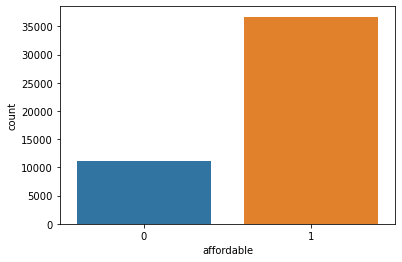

In [75]:
sns.countplot(data=University, x='affordable')
plt.show()

## 2.1 Join Datasets

In [76]:
from pandasql import sqldf

# Define the SQL query
combine_tables_query = """
SELECT DISTINCT 
        uni.UNITID,
        uni.INSTNM,
        uni.STABBR,
        uni.CITY,
        uni.REGION,
        uni.ADM_RATE_ALL,
        uni.SAT_AVG_ALL,
        uni.COSTT4_A,
        uni.TUITIONFEE_IN,
        uni.TUITIONFEE_OUT,
        uni.MN_EARN_WNE_INDEP1_P10,
        uni.PREDDEG,
        uni.CONTROL,
        pov.Stabr AS state_abbr,
        pov.Area_name_with_state,
        pov.POVALL_2021,
        pov.CI90LBALL_2021,
        pov.CI90UBALL_2021,
        pov.MEDHHINC_2021,
        pov.CI90LBINC_2021,
        pov.CI90UBINC_2021,
        unemp.Unemployment_rate_2000,
        unemp.Unemployment_rate_2001,
        unemp.Unemployment_rate_2002,
        unemp.Unemployment_rate_2003,
        unemp.Unemployment_rate_2004,
        unemp.Unemployment_rate_2005,
        unemp.Unemployment_rate_2006,
        unemp.Unemployment_rate_2007,
        unemp.Unemployment_rate_2008,
        unemp.Unemployment_rate_2009,
        unemp.Unemployment_rate_2010,
        unemp.Unemployment_rate_2011,
        unemp.Unemployment_rate_2013,
        unemp.Unemployment_rate_2014,
        unemp.Unemployment_rate_2015,
        unemp.Unemployment_rate_2016,
        unemp.Unemployment_rate_2017,
        unemp.Unemployment_rate_2018,
        unemp.Unemployment_rate_2019,
        unemp.Unemployment_rate_2020,
        unemp.Unemployment_rate_2021,
        unemp.Unemployment_rate_2022,
        unemp.Median_Household_Income_2021,
        net.avg_net_price_grants_scholarship_2020_2021,
        net.avg_net_price_grants_scholarship_2019_2020,
        net.avg_net_price_grants_scholarship_2018_2019,
        net.avg_net_price_grants_scholarship_2017_2018,
        net.avg_net_price_grants_scholarship_2016_2017,
        net.avg_net_price_grants_scholarship_2015_2016,
        net.avg_net_price_grants_scholarship_2014_2015,
        net.avg_net_price_grants_scholarship_2013_2014,
        net.avg_net_price_grants_scholarship_2012_2013,
        net.avg_net_price_grants_scholarship_2011_2012,
        unemp.Unemployment_rate_2012,
        uni.affordable
FROM University uni
JOIN Poverty pov ON uni.STABBR = pov.Stabr
JOIN Unemployment unemp ON pov.FIPS_Code = unemp.FIPS_Code
JOIN NetPrice net ON uni.INSTNM = net.institution_name
WHERE uni.year = 2022
"""

# Execute the SQL query on the Pandas DataFrames
df = sqldf(combine_tables_query, globals())

# Display the result
df.head()

,unitid,instnm,stabbr,city,region,adm_rate_all,sat_avg_all,costt4_a,tuitionfee_in,tuitionfee_out,...,avg_net_price_grants_scholarship_2018_2019,avg_net_price_grants_scholarship_2017_2018,avg_net_price_grants_scholarship_2016_2017,avg_net_price_grants_scholarship_2015_2016,avg_net_price_grants_scholarship_2014_2015,avg_net_price_grants_scholarship_2013_2014,avg_net_price_grants_scholarship_2012_2013,avg_net_price_grants_scholarship_2011_2012,unemployment_rate_2012,affordable
0,100654,Alabama A & M University,AL,Normal,Southeast (AL AR FL GA KY LA MS NC SC TN VA WV),0.716006,954.0,21924.0,10024.0,18634.0,...,14604.0,13956.0,15812.0,15547.0,13203.0,14746.0,12887.0,11108.0,8.2,1
1,100654,Alabama A & M University,AL,Normal,Southeast (AL AR FL GA KY LA MS NC SC TN VA WV),0.716006,954.0,21924.0,10024.0,18634.0,...,14604.0,13956.0,15812.0,15547.0,13203.0,14746.0,12887.0,11108.0,7.1,1
2,100654,Alabama A & M University,AL,Normal,Southeast (AL AR FL GA KY LA MS NC SC TN VA WV),0.716006,954.0,21924.0,10024.0,18634.0,...,14604.0,13956.0,15812.0,15547.0,13203.0,14746.0,12887.0,11108.0,7.7,1
3,100654,Alabama A & M University,AL,Normal,Southeast (AL AR FL GA KY LA MS NC SC TN VA WV),0.716006,954.0,21924.0,10024.0,18634.0,...,14604.0,13956.0,15812.0,15547.0,13203.0,14746.0,12887.0,11108.0,11.8,1
4,100654,Alabama A & M University,AL,Normal,Southeast (AL AR FL GA KY LA MS NC SC TN VA WV),0.716006,954.0,21924.0,10024.0,18634.0,...,14604.0,13956.0,15812.0,15547.0,13203.0,14746.0,12887.0,11108.0,8.8,1


# 3. Exploratory Data Analysis

In [77]:
# get number of rows and columns
print('Number of Rows in University - ', University.shape[0])
print('Number of Columns in University - ', University.shape[1], '\n')

print('Number of Rows in NetPrice - ', NetPrice.shape[0])
print('Number of Columns in NetPrice - ', NetPrice.shape[1], '\n')

print('Number of Rows in Poverty - ', Poverty.shape[0])
print('Number of Columns in Poverty - ', Poverty.shape[1], '\n')

print('Number of Rows in Unemployment - ', Unemployment.shape[0])
print('Number of Columns in Unemployment - ', Unemployment.shape[1], '\n')

Number of Rows in University -  47855
Number of Columns in University -  34 

Number of Rows in NetPrice -  3240
Number of Columns in NetPrice -  63 

Number of Rows in Poverty -  3195
Number of Columns in Poverty -  35 

Number of Rows in Unemployment -  3277
Number of Columns in Unemployment -  100 



## 3.1 Data Types and NULLS

In [78]:
# get number of rows and columns
print('Number of Rows - ', df.shape[0])
print('Number of Columns - ', df.shape[1], '\n')

# inspect datatypes and nulls
data_types = df.dtypes
data_types = pd.DataFrame(data_types)
data_types = data_types.assign(Null_Values = 
                               df.isnull().sum())
data_types.reset_index(inplace = True)
data_types.rename(columns={0:'Data Type',
                          'index': 'Field',
                          'Null_Values': "Nulls"})

Number of Rows -  137872
Number of Columns -  56 



,Field,Data Type,Nulls
0,unitid,int64,0
1,instnm,object,0
2,stabbr,object,0
3,city,object,0
4,region,object,0
5,adm_rate_all,float64,0
6,sat_avg_all,float64,48619
7,costt4_a,float64,4001
8,tuitionfee_in,float64,0
9,tuitionfee_out,float64,0


## 3.2 Summary Statistics

In [79]:
#summary statistics
stats = pd.DataFrame(df.describe()).T
stats

,count,mean,std,min,25%,50%,75%,max
unitid,137872.0,215348.687435,93979.963627,100654.000000,155812.000000,198899.000000,227331.000000,497268.0
adm_rate_all,137872.0,0.733948,0.206004,0.039152,0.626667,0.776997,0.890354,1.0
sat_avg_all,89253.0,1151.858660,129.362088,776.000000,1064.000000,1127.000000,1228.000000,1537.0
costt4_a,133871.0,36742.799083,16320.646884,8118.000000,23078.000000,33560.000000,47588.000000,81531.0
tuitionfee_in,137872.0,23755.840555,15257.251778,480.000000,10044.000000,19469.000000,34481.000000,66064.0
tuitionfee_out,137872.0,27619.961624,13156.366922,480.000000,17488.000000,25570.000000,35500.000000,66064.0
mn_earn_wne_indep1_p10,101839.0,50801.502371,15799.219146,23400.000000,41200.000000,48300.000000,55700.000000,224600.0
unemployment_rate_2000,137844.0,4.396701,1.598401,1.300000,3.400000,4.100000,5.100000,17.3
unemployment_rate_2001,137844.0,5.086958,1.707137,1.600000,4.000000,4.800000,5.800000,17.6
unemployment_rate_2002,137844.0,5.928520,1.811223,1.600000,4.800000,5.700000,6.800000,19.6


Outliers with Z-score (Threshold 3)

In [80]:
# In-state tuition data
tuitionfee_in_data = df['tuitionfee_in']

# Z-scores
z_scores_in = (tuitionfee_in_data - np.mean(tuitionfee_in_data)) / np.std(tuitionfee_in_data)
threshold = 3

# Find indices of outliers
outliers_in = np.where(np.abs(z_scores_in) > threshold)[0]

# Detail information about outliers
outlier_details = df.iloc[outliers_in]

# Print information about outliers
print("Outliers in tuitionfee_in:")
print(outlier_details)

# Summary statistics
print("\nSummary Statistics:")
print("Mean Tuition Fee:", np.mean(tuitionfee_in_data))
print("Median Tuition Fee:", np.median(tuitionfee_in_data))
print("Standard Deviation:", np.std(tuitionfee_in_data))
print("Number of Outliers:", len(outliers_in))

Outliers in tuitionfee_in:
Empty DataFrame
Columns: [unitid, instnm, stabbr, city, region, adm_rate_all, sat_avg_all, costt4_a, tuitionfee_in, tuitionfee_out, mn_earn_wne_indep1_p10, preddeg, control, state_abbr, area_name_with_state, povall_2021, ci90lball_2021, ci90uball_2021, medhhinc_2021, ci90lbinc_2021, ci90ubinc_2021, unemployment_rate_2000, unemployment_rate_2001, unemployment_rate_2002, unemployment_rate_2003, unemployment_rate_2004, unemployment_rate_2005, unemployment_rate_2006, unemployment_rate_2007, unemployment_rate_2008, unemployment_rate_2009, unemployment_rate_2010, unemployment_rate_2011, unemployment_rate_2013, unemployment_rate_2014, unemployment_rate_2015, unemployment_rate_2016, unemployment_rate_2017, unemployment_rate_2018, unemployment_rate_2019, unemployment_rate_2020, unemployment_rate_2021, unemployment_rate_2022, median_household_income_2021, avg_net_price_grants_scholarship_2020_2021, avg_net_price_grants_scholarship_2019_2020, avg_net_price_grants_schola

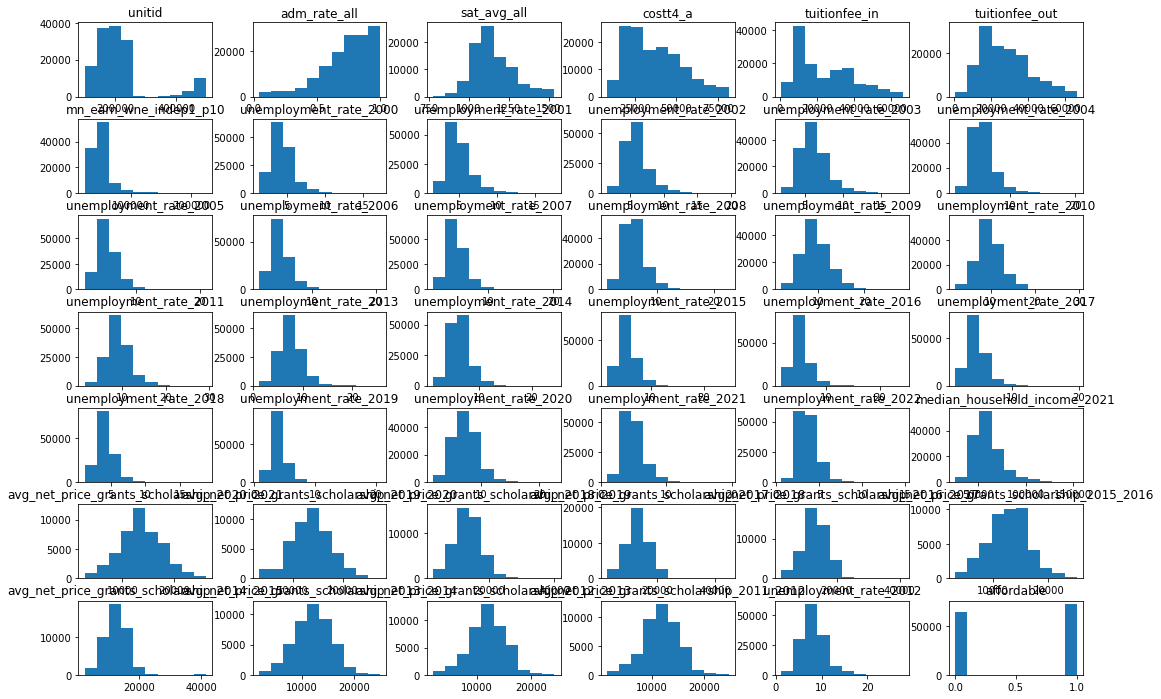

In [81]:
df.hist(grid=False, figsize=(18,12))
plt.show()

## Multicollinearity Test

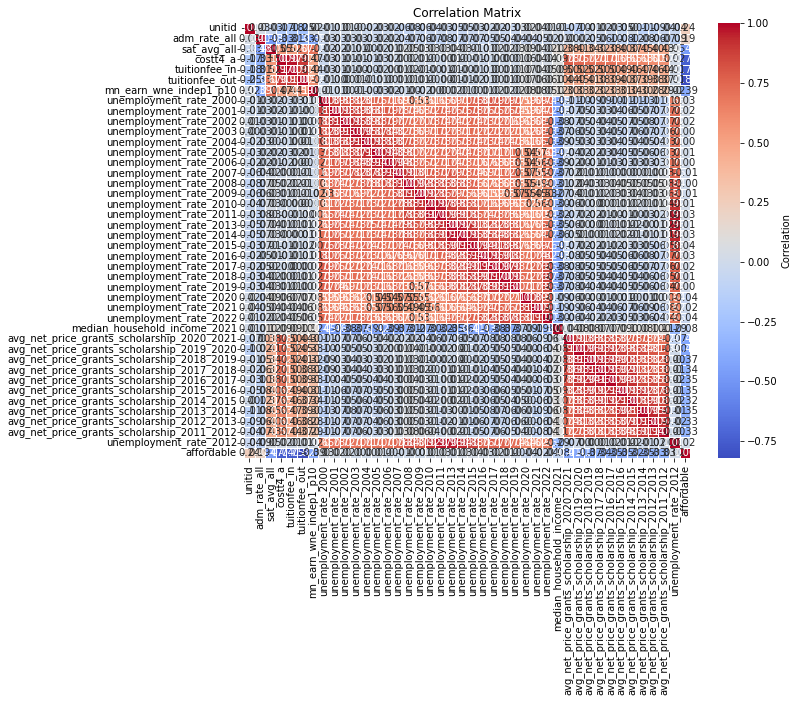

In [82]:
# assign correlation function to new variable
corr = df.corr()
corr

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, mask=corr.isnull(), cbar_kws={'label': 'Correlation'})
plt.title('Correlation Matrix')
plt.show()

In [83]:
# This is not representative of what we will drop yet. Of course in-state and out-of-state tutition of correlated, but will not be dropped. 
# Included it in case we find something interesting on joined table

In [84]:
# Calculate the correlation of affordability with all other attributes
correlation_with_target = df.corrwith(df['affordable'])

# Define correlation thresholds
upper_threshold = 0.4
lower_threshold = -0.4

# Get attributes above and below thresholds
above_threshold = correlation_with_target[correlation_with_target.abs() > upper_threshold]
below_threshold = correlation_with_target[correlation_with_target.abs() < lower_threshold]

# Show most correlated attributes
print(above_threshold)
print(below_threshold)

sat_avg_all                                  -0.471855
costt4_a                                     -0.743210
tuitionfee_in                                -0.751890
tuitionfee_out                               -0.821012
avg_net_price_grants_scholarship_2020_2021   -0.408468
avg_net_price_grants_scholarship_2019_2020   -0.407662
affordable                                    1.000000
dtype: float64
Series([], dtype: float64)


In [85]:
cor_matrix = df.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),
                                     k=1).astype(bool))

to_drop = [column for column in upper_tri.columns if 
           any(upper_tri[column] > 0.80)]
print('Columns with chance of multicollinearity: %s'%to_drop)

Columns with chance of multicollinearity: ['tuitionfee_in', 'tuitionfee_out', 'unemployment_rate_2001', 'unemployment_rate_2002', 'unemployment_rate_2003', 'unemployment_rate_2004', 'unemployment_rate_2005', 'unemployment_rate_2006', 'unemployment_rate_2007', 'unemployment_rate_2008', 'unemployment_rate_2009', 'unemployment_rate_2010', 'unemployment_rate_2011', 'unemployment_rate_2013', 'unemployment_rate_2014', 'unemployment_rate_2015', 'unemployment_rate_2016', 'unemployment_rate_2017', 'unemployment_rate_2018', 'unemployment_rate_2019', 'unemployment_rate_2021', 'unemployment_rate_2022', 'avg_net_price_grants_scholarship_2019_2020', 'avg_net_price_grants_scholarship_2018_2019', 'avg_net_price_grants_scholarship_2017_2018', 'avg_net_price_grants_scholarship_2016_2017', 'avg_net_price_grants_scholarship_2015_2016', 'avg_net_price_grants_scholarship_2014_2015', 'avg_net_price_grants_scholarship_2013_2014', 'avg_net_price_grants_scholarship_2012_2013', 'avg_net_price_grants_scholarship_

# 4. Data Preparation

### Handle Duplicate, Null, and Multicollinearity Features

In [86]:
# Drop redundant rows
df = df.drop_duplicates()

In [87]:
# Get null values for each column in the university dataset
null_cols = df.isnull().sum()
total_rows = df['instnm'].count()
percent_col_null = null_cols/total_rows * 100
percent_col_null.sort_values(ascending=False)

avg_net_price_grants_scholarship_2011_2012    68.502669
avg_net_price_grants_scholarship_2012_2013    68.154520
avg_net_price_grants_scholarship_2013_2014    67.896310
avg_net_price_grants_scholarship_2014_2015    67.421957
avg_net_price_grants_scholarship_2015_2016    67.395120
avg_net_price_grants_scholarship_2016_2017    67.136184
avg_net_price_grants_scholarship_2017_2018    67.136184
avg_net_price_grants_scholarship_2018_2019    67.136184
avg_net_price_grants_scholarship_2019_2020    66.922218
avg_net_price_grants_scholarship_2020_2021    66.922218
sat_avg_all                                   35.263868
mn_earn_wne_indep1_p10                        26.135111
costt4_a                                       2.901967
unemployment_rate_2005                         0.142161
unemployment_rate_2006                         0.142161
unemployment_rate_2008                         0.020309
unemployment_rate_2009                         0.020309
unemployment_rate_2000                         0

In [88]:
# Get the size of the dataframe before dropping null values
df.shape

(137872, 56)

In [89]:
# Drop null values
df = df.dropna()

In [90]:
# Get the size of the dataframe after dropping null values
df.shape

(32944, 56)

## 4.3 Additional Visualizations to Understand Bias

In [91]:
# Distribution of degree granted at universities
degree_count_query = """
SELECT preddeg, COUNT(preddeg) as count 
FROM (
    SELECT DISTINCT instnm, preddeg
    FROM df
) AS unique_degrees
GROUP BY preddeg
ORDER BY count DESC;
"""
# Execute the SQL query on the Pandas DataFrames
degree_count = sqldf(degree_count_query, globals())
degree_count

,preddeg,count
0,Predominantly bachelor's-degree granting,349
1,Predominantly associate's-degree granting,36
2,Predominantly certificate-degree granting,2


### 4.3.1 Barplot of Primary Degree Granted at Universities

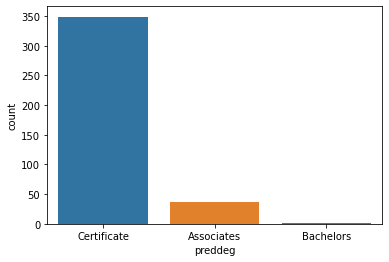

In [92]:
degree_labels = ['Certificate', 'Associates', 'Bachelors']

sns.barplot(data=degree_count, x='preddeg', y='count')
plt.xticks(ticks=range(len(degree_labels)), labels=degree_labels)
plt.show()

In [93]:
# Certificates are under-represented, with only 2 observations so these will be removed
df = df[df.preddeg != 'Predominantly certificate-degree granting']

degrees = {'Predominantly bachelor\'s-degree granting': 2,
           'Predominantly associate\'s-degree granting': 1}

# Replace the values in the preddeg column using the mapping dictionary
df['preddeg'] = df['preddeg'].map(degrees)

In [94]:
# Distribution of university control system
control_count_query = """
SELECT control, COUNT(control) as count 
FROM (
    SELECT DISTINCT instnm, control
    FROM df
) AS unique_count
GROUP BY control
ORDER BY count DESC;
"""
# Execute the SQL query on the Pandas DataFrames
control_count = sqldf(control_count_query, globals())
control_count

,control,count
0,Public,384
1,Private nonprofit,1


### 4.3.2 Barplot of University Funding Control

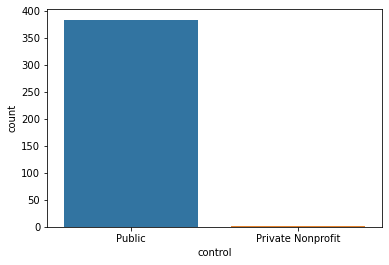

In [95]:
control_labels = ['Public','Private Nonprofit']

sns.barplot(data=control_count, x='control', y='count')
plt.xticks(ticks=range(len(control_labels)), labels=control_labels)
plt.show()

# Only one observation of private non-profit universities were found, thus control labels will be removed from the dataset

In [96]:
# Define all U.S. regions. Since these are cetegories, we might consider using one-hot encoder
regions = {'Southeast (AL AR FL GA KY LA MS NC SC TN VA WV)':'Southeast',
           'Great Lakes (IL IN MI OH WI)':'Great Lakes',
           'Southwest (AZ NM OK TX)':'Southwest',
           'Mid East (DE DC MD NJ NY PA)':'Mid East',
           'Plains (IA KS MN MO NE ND SD)':'Plains', 
           'Far West (AK CA HI NV OR WA)':'Far East',
           'Rocky Mountains (CO ID MT UT WY)':'Rocky Mountains', 
           'New England (CT ME MA NH RI VT)':'New England', 
           'U.S. Service Schools':'U.S. Service Schools'}

df['region'] = df['region'].replace(regions)

In [97]:
# Distribution of university control system
region_count_query = """
SELECT region, COUNT(*) as count 
FROM (
    SELECT DISTINCT instnm, region
    FROM df
) AS unique_region
GROUP BY region
ORDER BY count DESC;
"""
# Execute the SQL query on the Pandas DataFrames
region_count = sqldf(region_count_query, globals())
region_count

,region,count
0,Southeast,119
1,Great Lakes,77
2,Mid East,53
3,Southwest,47
4,Plains,39
5,New England,22
6,Rocky Mountains,18
7,Far East,10


### 4.3.3 Boxplot of U.S. Regions, SAT Scores, and Affordability

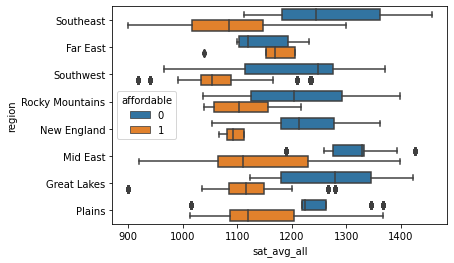

<Figure size 720x576 with 0 Axes>

In [98]:
sns.boxplot(data=df, y='region', x='sat_avg_all', hue='affordable')
plt.figure(figsize=(10, 8))
plt.show()

### 4.3.4 Boxplot of U.S. Regions and Admissions Rate

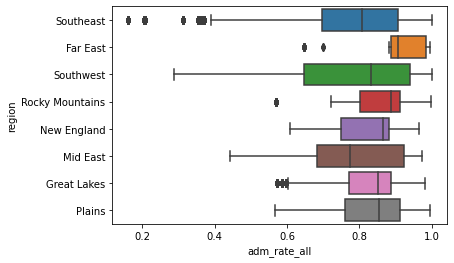

<Figure size 720x576 with 0 Axes>

In [99]:
sns.boxplot(data=df, y='region', x='adm_rate_all')
plt.figure(figsize=(10, 8))
plt.show()

### 4.3.5 Scatterplot of Admissions Rate, Overall Cost of Tuition, and Affordability

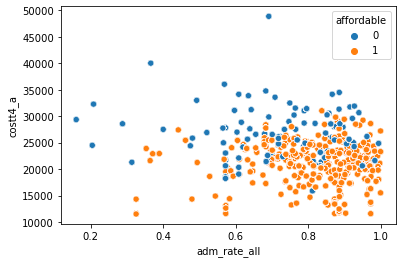

<Figure size 720x576 with 0 Axes>

In [100]:
sns.scatterplot(data=df, x='adm_rate_all', y='costt4_a', hue='affordable')
plt.figure(figsize=(10, 8))
plt.show()

### 4.3.6 Histogram of 2021 Median Household Income and Enrollment in University Funding Control

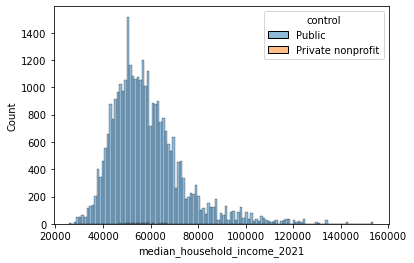

<Figure size 720x576 with 0 Axes>

In [101]:
sns.histplot(data=df, x='median_household_income_2021', hue='control')
plt.figure(figsize=(10, 8))
plt.show()

In [102]:
# Uploading pre-processed data as a csv
df.to_csv('combined_data.csv')

## 4.4 Encoding Categorical Labels

In [103]:
df = pd.read_csv('combined_data.csv')
drop_categorical = ['instnm','stabbr','city','state_abbr','control','area_name_with_state']
df = df.drop(columns=drop_categorical)
df = df.drop(df.columns[0], axis=1)
df.head(1)

,unitid,region,adm_rate_all,sat_avg_all,costt4_a,tuitionfee_in,tuitionfee_out,mn_earn_wne_indep1_p10,preddeg,povall_2021,...,avg_net_price_grants_scholarship_2018_2019,avg_net_price_grants_scholarship_2017_2018,avg_net_price_grants_scholarship_2016_2017,avg_net_price_grants_scholarship_2015_2016,avg_net_price_grants_scholarship_2014_2015,avg_net_price_grants_scholarship_2013_2014,avg_net_price_grants_scholarship_2012_2013,avg_net_price_grants_scholarship_2011_2012,unemployment_rate_2012,affordable
0,100654,Southeast,0.716006,954.0,21924.0,10024.0,18634.0,38100.0,2,800848,...,14604.0,13956.0,15812.0,15547.0,13203.0,14746.0,12887.0,11108.0,8.2,1


In [104]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Encoding U.S. regions 
encoded_df = pd.get_dummies(df, columns=['region'])

encoded_df.head()

,unitid,adm_rate_all,sat_avg_all,costt4_a,tuitionfee_in,tuitionfee_out,mn_earn_wne_indep1_p10,preddeg,povall_2021,ci90lball_2021,...,unemployment_rate_2012,affordable,region_Far East,region_Great Lakes,region_Mid East,region_New England,region_Plains,region_Rocky Mountains,region_Southeast,region_Southwest
0,100654,0.716006,954.0,21924.0,10024.0,18634.0,38100.0,2,800848,782169,...,8.2,1,0,0,0,0,0,0,1,0
1,100654,0.716006,954.0,21924.0,10024.0,18634.0,38100.0,2,6296,4772,...,7.1,1,0,0,0,0,0,0,1,0
2,100654,0.716006,954.0,21924.0,10024.0,18634.0,38100.0,2,25526,21599,...,7.7,1,0,0,0,0,0,0,1,0
3,100654,0.716006,954.0,21924.0,10024.0,18634.0,38100.0,2,5089,3773,...,11.8,1,0,0,0,0,0,0,1,0
4,100654,0.716006,954.0,21924.0,10024.0,18634.0,38100.0,2,4204,3324,...,8.8,1,0,0,0,0,0,0,1,0


## 4.5 Normalize Numerical Values

In [106]:
from sklearn.preprocessing import MinMaxScaler

# Columns to apply MinMaxScaler
numerical_features = ['costt4_a','tuitionfee_in','tuitionfee_out', 'mn_earn_wne_indep1_p10', 'povall_2021','medhhinc_2021',
                      'unemployment_rate_2000','unemployment_rate_2001','unemployment_rate_2002','unemployment_rate_2003', 'unemployment_rate_2004','unemployment_rate_2005',
                      'unemployment_rate_2006', 'unemployment_rate_2007','unemployment_rate_2008','unemployment_rate_2009','unemployment_rate_2010','unemployment_rate_2011',
                      'unemployment_rate_2013','unemployment_rate_2014','unemployment_rate_2015','unemployment_rate_2016','unemployment_rate_2017', 'unemployment_rate_2018',
                      'unemployment_rate_2019', 'unemployment_rate_2020', 'unemployment_rate_2021', 'unemployment_rate_2022','median_household_income_2021', 
                      'avg_net_price_grants_scholarship_2020_2021','avg_net_price_grants_scholarship_2019_2020','avg_net_price_grants_scholarship_2018_2019', 
                      'avg_net_price_grants_scholarship_2017_2018', 'avg_net_price_grants_scholarship_2016_2017', 'avg_net_price_grants_scholarship_2015_2016', 
                      'avg_net_price_grants_scholarship_2014_2015', 'avg_net_price_grants_scholarship_2013_2014', 'avg_net_price_grants_scholarship_2012_2013', 'avg_net_price_grants_scholarship_2011_2012', 
                      'unemployment_rate_2012',]

scaler = MinMaxScaler()

# Store scaled values into new df
scaled_df = encoded_df.copy() 
scaled_df[numerical_features] = scaler.fit_transform(encoded_df[numerical_features])

# Print scaled features
scaled_df.head()

,unitid,adm_rate_all,sat_avg_all,costt4_a,tuitionfee_in,tuitionfee_out,mn_earn_wne_indep1_p10,preddeg,povall_2021,ci90lball_2021,...,unemployment_rate_2012,affordable,region_Far East,region_Great Lakes,region_Mid East,region_New England,region_Plains,region_Rocky Mountains,region_Southeast,region_Southwest
0,100654,0.716006,954.0,0.278705,0.262365,0.31364,0.193314,2,0.194248,782169,...,0.311404,1,0,0,0,0,0,0,1,0
1,100654,0.716006,954.0,0.278705,0.262365,0.31364,0.193314,2,0.001526,4772,...,0.263158,1,0,0,0,0,0,0,1,0
2,100654,0.716006,954.0,0.278705,0.262365,0.31364,0.193314,2,0.006191,21599,...,0.289474,1,0,0,0,0,0,0,1,0
3,100654,0.716006,954.0,0.278705,0.262365,0.31364,0.193314,2,0.001234,3773,...,0.469298,1,0,0,0,0,0,0,1,0
4,100654,0.716006,954.0,0.278705,0.262365,0.31364,0.193314,2,0.001019,3324,...,0.337719,1,0,0,0,0,0,0,1,0


In [107]:
scaled_df.dtypes

unitid                                          int64
adm_rate_all                                  float64
sat_avg_all                                   float64
costt4_a                                      float64
tuitionfee_in                                 float64
tuitionfee_out                                float64
mn_earn_wne_indep1_p10                        float64
preddeg                                         int64
povall_2021                                   float64
ci90lball_2021                                  int64
ci90uball_2021                                  int64
medhhinc_2021                                 float64
ci90lbinc_2021                                  int64
ci90ubinc_2021                                  int64
unemployment_rate_2000                        float64
unemployment_rate_2001                        float64
unemployment_rate_2002                        float64
unemployment_rate_2003                        float64
unemployment_rate_2004      

# 5. Modeling

In [112]:
from sklearn.model_selection import train_test_split

# Define features and target variable
X = scaled_df.drop(columns=['affordable'])  
y = scaled_df['affordable']

# Split the data into train and temporary sets (70% train, 30% temp)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Split the temporary set into validation and test sets (50% for validation, 50% for test)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print the shapes of the resulting sets
print("Train set shape:", X_train.shape)
print("Validation set shape:", X_valid.shape)
print("Test set shape:", X_test.shape)

Train set shape: (22997, 56)
Validation set shape: (4928, 56)
Test set shape: (4928, 56)


In [113]:
# Save data splits to CSV files
X_train.to_csv('train_features.csv', index=False)
y_train.to_csv('train_labels.csv', index=False, header=False)
X_valid.to_csv('valid_features.csv', index=False)
y_valid.to_csv('valid_labels.csv', index=False, header=False)
X_test.to_csv('test_features.csv', index=False)
y_test.to_csv('test_labels.csv', index=False, header=False)

In [114]:
# Upload CSV files to S3
s3 = boto3.client('s3')

# Specify the bucket name
bucket_name = 'collegeaffordability317'

# Upload train data
s3.upload_file('train_features.csv', bucket_name, 'train/train_features.csv')
s3.upload_file('train_labels.csv', bucket_name, 'train/train_labels.csv')

# Upload validation data
s3.upload_file('valid_features.csv', bucket_name, 'validation/valid_features.csv')
s3.upload_file('valid_labels.csv', bucket_name, 'validation/valid_labels.csv')

# Upload test data
s3.upload_file('test_features.csv', bucket_name, 'test/test_features.csv')
s3.upload_file('test_labels.csv', bucket_name, 'test/test_labels.csv')

S3UploadFailedError: Failed to upload train_features.csv to collegeaffordability317/train/train_features.csv: An error occurred (AccessDenied) when calling the CreateMultipartUpload operation: Access Denied

In [115]:
# Create a subset based on correlated attributes
columns_to_include = ['sat_avg_all', 'costt4_a', 'avg_net_price_grants_scholarship_2020_2021',
                      'avg_net_price_grants_scholarship_2019_2020']

# Load the data from S3
bucket_name = 'collegeaffordability317'
s3 = boto3.client('s3')

# Download train data
s3.download_file(bucket_name, 'train/train_features.csv', 'train_features.csv')
s3.download_file(bucket_name, 'train/train_labels.csv', 'train_labels.csv')

# Load train data
X_train_corr = pd.read_csv('train_features.csv')[columns_to_include]
y_train_corr = pd.read_csv('train_labels.csv', header=None)[0]

# Download validation data
s3.download_file(bucket_name, 'validation/valid_features.csv', 'valid_features.csv')
s3.download_file(bucket_name, 'validation/valid_labels.csv', 'valid_labels.csv')

# Load validation data
X_valid_corr = pd.read_csv('valid_features.csv')[columns_to_include]
y_valid_corr = pd.read_csv('valid_labels.csv', header=None)[0]

# Download test data
s3.download_file(bucket_name, 'test/test_features.csv', 'test_features.csv')
s3.download_file(bucket_name, 'test/test_labels.csv', 'test_labels.csv')

# Load test data
X_test_corr = pd.read_csv('test_features.csv')[columns_to_include]
y_test_corr = pd.read_csv('test_labels.csv', header=None)[0]

### 5.1 Logistic Regression

In [116]:
# Train an inital logistic regression model
log_reg_model = LogisticRegression()
log_reg_model.fit(X_train_corr, y_train_corr)

# Predictions on validation set
y_valid_pred_corr = log_reg_model.predict(X_valid_corr)

# Evaluate the model on validation set
valid_accuracy = accuracy_score(y_valid_corr, y_valid_pred_corr)
print("Validation Accuracy:", valid_accuracy)

# Predictions on test set
y_test_pred_corr = log_reg_model.predict(X_test_corr)

# Evaluate the model on test set
test_accuracy = accuracy_score(y_test_corr, y_test_pred_corr)
print("Test Accuracy:", test_accuracy)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_valid_corr, y_valid_pred_corr))

Validation Accuracy: 0.7577903682719547
Test Accuracy: 0.763860785107244

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.16      0.25      1220
           1       0.78      0.95      0.86      3722

    accuracy                           0.76      4942
   macro avg       0.65      0.56      0.55      4942
weighted avg       0.72      0.76      0.71      4942



#### Finding Best Hyperparameters

In [123]:
# Define IAM role
role = sagemaker.get_execution_role()

# Set the region of the instance
my_region = boto3.session.Session().region_name 

# This line automatically looks for the XGBoost image URI and 
# builds an XGBoost container.
xgboost_container = sagemaker.image_uris.retrieve("xgboost", 
                                                  my_region, 
                                                  "latest")

print("Success - the MySageMakerInstance is in the " + my_region + \
      " region. You will use the " + xgboost_container + \
      " container for your SageMaker endpoint.")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
Success - the MySageMakerInstance is in the us-east-1 region. You will use the 811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest container for your SageMaker endpoint.


### 5.2 XG Boost

In [124]:
# Load the data from S3
bucket_name = 'collegeaffordability317'
s3 = boto3.client('s3')

sess = sagemaker.Session()
xgb = sagemaker.estimator.Estimator(xgboost_container,
                                    role, 
                                    instance_count=1, 
                                    instance_type='ml.m5.large',
                                    output_path='s3://{}/output'.format(bucket_name),
                                    sagemaker_session=sess)

# Parse in the hyperparameters
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [125]:
# Create a new model using hyperparameters
# Fit the model
xgb.fit({'train': sagemaker.inputs.TrainingInput('s3://{}/train'.format(bucket_name), content_type='text/csv')})

INFO:sagemaker:Creating training-job with name: xgboost-2024-04-02-03-03-31-339


2024-04-02 03:03:31 Starting - Starting the training job...
2024-04-02 03:03:46 Starting - Preparing the instances for training...
2024-04-02 03:04:30 Downloading - Downloading input data......
2024-04-02 03:05:15 Downloading - Downloading the training image...
2024-04-02 03:05:56 Training - Training image download completed. Training in progress..Arguments: train
[2024-04-02:03:05:59:INFO] Running standalone xgboost training.
[2024-04-02:03:05:59:INFO] Path /opt/ml/input/data/validation does not exist!
[2024-04-02:03:05:59:INFO] File size need to be processed in the node: 7.32mb. Available memory size in the node: 262.41mb
[2024-04-02:03:05:59:ERROR] Customer Error: Non-numeric value 'i' found in the header line 'instnm,stabbr,city,adm_rate_all,sat_avg_all,costt4...' of file 'train_features.csv'. CSV format require no header line in it. If header line is already removed, XGBoost does not accept non-numeric value in the data.
Traceback (most recent call last):
  File "/opt/amazon/lib/p

UnexpectedStatusException: Error for Training job xgboost-2024-04-02-03-03-31-339: Failed. Reason: ClientError: Artifact upload failed:Unable to upload file to s3://collegeaffordability317/output/xgboost-2024-04-02-03-03-31-339/profiler-output/system/incremental/2024040203/1712027100.algo-1.json (AccessDenied: Access Denied)

In [ ]:
from sagemaker.predictor import csv_serializer

# Deploy the model
xgb_predictor = xgb.deploy(initial_instance_count=1, instance_type='ml.m5.large')

# Specify the test dataset location
test_location = 's3://{}/test/test_features.csv'.format(bucket_name)

# Set up the predictor to accept CSV input and parse the response as JSON
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = sagemaker.deserializers.JSONDeserializer()

# Evaluate the model on the test data
test_predictions = xgb_predictor.predict(test_location)

In [ ]:
# Delete the endpoint to keep costs minimal
xgb_predictor.delete_endpoint()

### 5.3 Random Forrest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 500, max_depth = 4, max_features = 3, bootstrap = True, random_state = 508)
rf.fit(X_train, y_train)

y_valid_pred = rf.predict(X_valid)

# Calculate accuracy on the validation set
accuracy = accuracy_score(y_valid, y_valid_pred)
print("Accuracy on validation set:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_valid, y_valid_pred))

#### Release Sagemaker Resources

In [ ]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}

In [ ]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>